# Приоритизация гипотез по увеличению выручки интернет-магазина и анализ результатов проведенного А/В теста

## Импорт библиотек

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Изучение данных и предобработка

### Датасет с гипотезами

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


> Датасет совсем небольшой, его легко изучить визуально.  
>* Пропусков нет, дубликатов нет, странных значений нет  
>* Имеет смысл привести заголовки к нижнему регистру, чтобы было удобнее работать

In [4]:
#приведем заголовки столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower() 
#display(hypothesis)

### Датасет с заказами

In [7]:
orders = pd.read_csv('/datasets/orders.csv', sep=',')
orders.head(10)


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


>1. Попусков нет 
>2. Стоит проверить данные на дубликаты и поискать выбивающиеся значения (например, отрицательные в столбце revenue)  
>3. Тип данных в date привести к временному типу  
>4. Можно переименовать колонки для удобства 

In [15]:
#проверяем данные на дубликаты
print('Количество дубликатов в датасете orders:', orders.duplicated().sum()) 

Количество дубликатов в датасете orders: 0


In [16]:
#поищем отрицательные значения в revenue
orders.describe() 

,transaction_id,visitor_id,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [17]:
#переименуем столбцы, чтобы было удобнее
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group'] 
#orders.head()


In [36]:
#приведем данные в столбце с датой к временному типу
orders['date'] = orders['date'].astype('datetime64[D]') 
#orders.info()

### Датасет с пользователями

In [37]:
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
display(visitors)
visitors.info()
visitors.describe()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [38]:
#проверяем данные на дубликаты
print('Количество дубликатов в датасете visitors:', visitors.duplicated().sum())

Количество дубликатов в датасете visitors: 0


In [39]:
#приведем данные в столбце с датой к временному типу
visitors['date'] = visitors['date'].astype('datetime64[D]') 
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


> Пропусков нет, странных значений нет, дубликатов нет  
> Данные в столбце с датой приведены к временному типу

## Приоритизация гипотез.

### Применение фреймворка ICE для приоритизации гипотез. 

In [13]:
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [14]:
#Приоритезируем по ICE
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


По **ICE** самые приоритетные гипотезы под индексами 8, 0, 7 

In [15]:
#Приоритезируем по RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


По **RICE** самые приоритетные гипотезы под индексами 7, 2, 0 и 6

>RICE дал нам отличные от ICE показатели, поскольку в ICE мы не учитывали охват пользователей, которых изменения затронут. Поскольку целью проекта является увеличение выручки, считаю, что показатель Reach является важнейшей составляющей приоритезации, поэтому при составлении приоритетов будем учитывать именно этот метод.  
>
>Приоритетные гипотезы:  
>1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - индекс 7
>2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - индекс 2  
>3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - индекс 0  
>4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию - индекс 6  
>
>Самой приритетной гипотезой является **гипотеза 7-Добавить форму подписки на все основные страницы**  - параметр RICE у нее сильно выбивается от остальных и состаялет 112 баллов, что в 2 раза выше, второй по приоритету гипотезы. Стоит сосредоточить усилия на ней

## Анализ A/B-теста

### Изучение кумулятивной выручки, среднего чека и конверсии. Анализ изменений показателей. 

Объявим датафрейм cumulative со столбцами:  

date — дата;  
group — группа A/B-теста (A или B);  
orders — кумулятивное количество заказов на указанную дату в указанной группе;  
buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);  
visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.  

In [40]:
#создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [41]:
#Соберём агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated.head(10)



,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996
499,2019-08-04,A,84,77,425699
498,2019-08-04,B,78,75,489567
698,2019-08-05,A,109,100,549917
699,2019-08-05,B,101,98,581995


In [42]:
#Соберём агрегированные кумулятивные по дням данные о пользователях
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head(10)


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803
499,2019-08-04,A,2562
498,2019-08-04,B,2573
698,2019-08-05,A,3318
699,2019-08-05,B,3280


In [43]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


#### Графики

In [44]:
# создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [45]:
# создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


##### График кумулятивной выручки по группам. Выводы и предположения

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

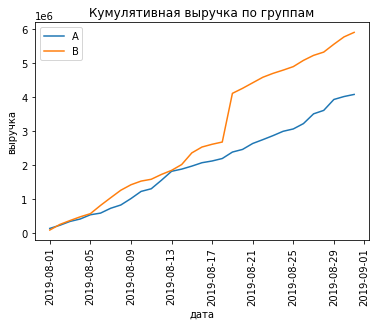

In [46]:
# Строим график кумулятивной выручки по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A') #график кумулятивной выручки группы А
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B') #график кумулятивной выручки группы B
plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.xlabel('дата')
plt.ylabel('выручка')
plt.xticks(rotation=90)

>Выручка в обеих группах теста довольно равномерно увеличивается на протяжении всего периода теста. Оба графика имеют точки резкого роста выручки. В группе А можно выделить 3 таких точки, а в группе В одну. В групе А увеличения не сильно значительны, а вот в группе B рост огромен. С 250 тысяч рост был до 400 тысяч буквально за день и, кстати, потом, график все еще растет до самого завершения теста.  
В групее В выручка явно лучше

##### График кумулятивнго среднего чека по группам. Выводы и предположения

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

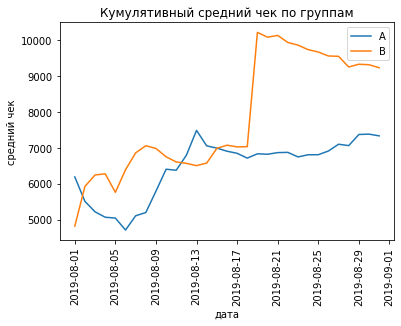

In [47]:
# Строим график кумулятивного среднего чека по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A') #график кумулятивного среднего чека группы А
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B') #график кумулятивного среднего чека группы B
plt.legend()
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.xticks(rotation=90)

>В группе А средний чек в начале теста с 6 тысяч упал примерно до 4,5, за 8 дней показывал стабильный рост и увеличился до 7,5 тысяч, упал до 6,8 и до самого конца теста показывал довольно стабильный результат, в какие-то дни увеличиваясь, в какие-то дни уменьшаясь. Стабильность началась примерно через 2 недели (половина от всего времени проведения теста)  
>
>В группе B твориться хаос. В начале теста эта группа наоборот, показаывала, не очень хороший средний чек, потом резко возросла, упала и через неделю поднялась до первого пика в 7 тысяч (рост с 4х), плавно упав к середине теста, пошла вверх и примерно через 4 дня резко подскочила с 7 до 10.5 тысяч, до самого конца теста наблюдается плавный спад. Хотелось бы разобраться еще сильнее с этой группой. Во-первых, средний чек продолжает падать к концу теста и мы не знаем на какой отметке он выровняется. Во-вторых кажется, что кто-то прикупил дорогих товаров, новинок, запасся "впрок". Так или иначе группа B не очень стабильна.  
>
>Однако средний чек в группе B все же держится выше, чем в группе А. 

##### График относительного изменения кумулятивного среднего чека группы B к группе А. Выводы и предположения

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

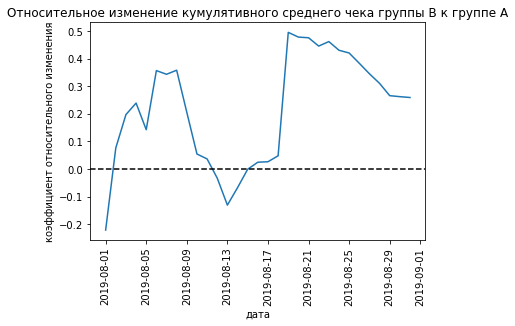

In [48]:
# Строим график относительного изменения кумулятивного среднего чека группы B к группе A
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']) #соберем данные в одном датафрейме
#mergedCumulativeRevenue.head()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1) # cтроим отношение средних чеков
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
plt.ylabel('коэффициент относительного изменения')
plt.xticks(rotation=90)


Довольно много точек различия между средними чеками групп. Точно стоит поискать дорогие заказы и выбросы

##### График кумулятивной конверсии по группам. Выводы и предположения

In [49]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeData.head()



,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [50]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataA.head()


,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


In [51]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
cumulativeDataB.head()

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793


(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

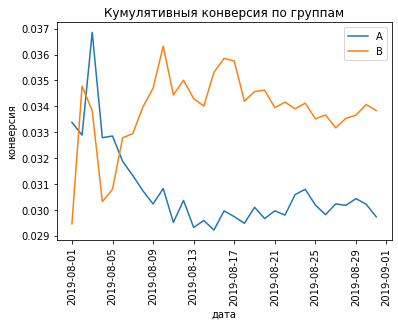

In [52]:
# Строим график кумулятивной конверсии по группам
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A') #график кумулятивной конверсии в группе А
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B') #график кумулятивной конверсии в группе В
plt.legend()
plt.title('Кумулятивныя конверсия по группам')
plt.xlabel('дата')
plt.ylabel('конверсия')
plt.xticks(rotation=90)

>В самом начале в обеих группах были сильные перпады в конверсии, конверсия группы А в один день вырсола сильно вверх и на следюущий уже также стремительно упала и продолжила падать. На 9й день теста конверсия не то, чтобы стабилизировалась, но продолжила динамику примерно в одном диапазоне. Хотя постоянной ее назвать нельзя.  
>
>В группе В в начале теста мы также можем наблюдать такой же резкий скачок и падение. Однако, в отличии от группы А, конверсия в этой группе растет. Достигнув пика еще пару раз растет и падает и дальше продолжает вести себя перемнчиво, падая и возрастая. За пару дне до окончания теста конверсия вдруг опять поползла вверх, а в день окончания упала. Продолжит ли она падать не понятно, т.к. все же тест в жтой групе хочется продлить.  
>
>Зато понятно, что коверсия группы В выше конверсии группы А, а графики скачут, как будто бы каждый день ситуация на сайте меняется и магазин проводит какие-то акции, увеличивающие конверсию в покупателя

##### График относительного изменения кумулятивной конверсии группы B к группе А. Выводы и предположения

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

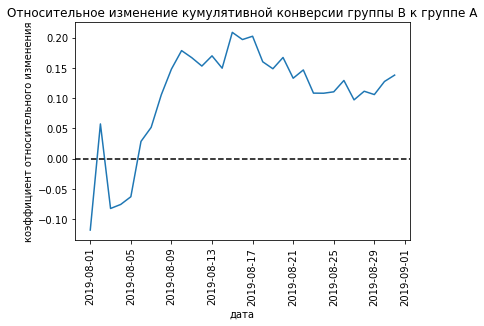

In [54]:
# Строим график 
mergedCumulativeConversion = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']) #соберем данные в одном датафрейме
#mergedCumulativeConversion.head()
plt.plot(mergedCumulativeConversion['date'], mergedCumulativeConversion['conversionB']/mergedCumulativeConversion['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('дата')
plt.ylabel('коэффициент относительного изменения')
plt.xticks(rotation=90)


>В начале теста группа B сильно проигрывала группе А, потом ее конверсия резко возросла и также резко упала за 2 дня. Далее стабильно росла и достигнув своего пика плавно пошла на спад, а сейчас опять растет

##### Точечный график количества заказов по пользователям. Выводы и предположения

In [55]:
#orders.head()

In [56]:
# считаем количество заказов на пользователя
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


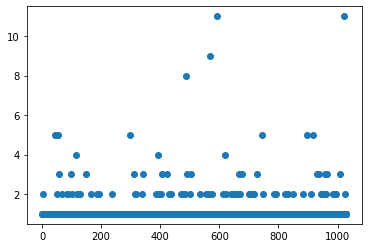

In [57]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 

>Большинство пользователей совершали по 1 заказу, но также много пользователей, кто делал 2 и даже 3 заказа. Нужно понять сколько таких пользователей. Больше трех заказов делали редко, это точно аномальные заказы

##### Перцентили количества заказов на пользователя

In [33]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


>Не более 5% пользователей заказывали в нашем магазине более 2х раз, и всего 1% сделал более 4х заказов. Думаю, стоит установить границу в 2 заказа и остеять аномальных пользователей по ней. 

##### Точечный график стоимостей заказов. Выводы и предположения

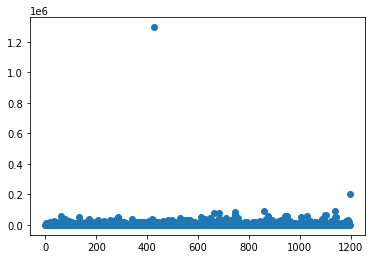

In [58]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

Кажется, что аномальных заказов у нас совсем немного. 

##### Перцентили стоимостей заказов

In [59]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


>Не более 5% пользователей совершали заказы стоимостью более 28000 рублей, и всего 1 % покупал товары более 58233 тысячи рублей. Планка в этом случае устанавливается в 28 000. 

#### Cтатистическая значимость

##### Расчет статистической значимости различий в конверсии между группами по «сырым» данным. Выводы и предположения

In [60]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']
#ordersByUsersA.head()

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']
#ordersByUsersB.head()


In [61]:
# Создадим переменные с количеством пользователей каждой группы на каждую дату

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
#visitorsADaily.head()
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
#visitorsBDaily.head()

In [62]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#sampleA.head()

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#sampleB.head()

In [39]:
#Применяем критерий Манна-Уитни
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1])) #p-value

0.017


>Статистистически значимые раздличия между группами есть

In [63]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.138


>Группа B выигрывает по конверсии с группой А почти на 14%

##### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. Выводы и предположения

In [64]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


> Cтатистических различий в среднем чеке по двум группам нет. Хотя средний чек группы B больще среднео чека группы А почти на 26%

##### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным. Выводы и предположения

In [65]:
#собираем пользователей с большим количеством заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitor_id'],
    ],
    axis=0,
)

usersWithManyOrders.head()

227    2038680547
278    2458001652
499    4256040402
326    2378935119
340    2458001652
Name: visitor_id, dtype: int64

In [66]:
#собираем пользователей со слишком дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitor_id']
usersWithExpensiveOrders.head()

34     834683205
60    4256040402
73    2947100995
77     787824685
78    3288820196
Name: visitor_id, dtype: int64

In [67]:
#объединяем пользователей
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

568     113298937
1099    148427295
461     154576532
928     204675465
684     358944393
Name: visitor_id, dtype: int64
(86,)


Всего 86 аномальных пользователей

In [68]:
#Объявим переменные sampleAFiltred и sampleBFiltred

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#sampleAFiltered.head()

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#sampleBFiltered.head()

**Формулировка гипотез:**  
Нулевая гипотеза - статистически значимых различий между конверсиями групп А и В нет   
Альтернативная гипотеза - статистически значимые различия между конверсиями групп А и В есть


In [69]:
#Применяем критерий Манна-Уитни
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1])) #p-value

0.023


>P-value меньше 0.05, значит нулевую гипотезу отвергаем. Статистически значимые различия между конверсиями групп А и В есть

In [47]:
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

0.149


>Конверсия группы B выше конверсии группы А почти на 15%

##### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным. Выводы и предположения

**Формулировка гипотез:**  
Нулевая гипотеза - статистически значимых различий между средними чеками групп А и В нет 
Альтернативная гипотеза - статистически значимые различия между средними чеками групп А и В есть

In [70]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.866
-0.002


P-value не сильно увеличился, статистической разницы между средними чеками нет. Но теперь группа B проигрывает группе А на 0,2% Не особенно много

## Результаты анализа

1. Статистической разницы между средним чеком групп А и В ни по сырым, ни по очищенным данным нет  
2. Статистичесая разница между конверсиями групп А и В есть и по сырым, и по очищенным данным  
3. Группа В выигрывает в конверсии на 15%  
4. График относительного изменения среднего чека группы В по отношению к группе А не очень стабилен, но показал сильный рост и имеет тенденцию к стабилизации в самом конце  
5. График относительного изменения кумулятивной конверсии группы В по отношению к группе А растет в концу теста

>Стоит остановить тест и зафиксировать лучший результат у групппы B